In [1]:
# for first run on vast.ai
%pip install transformer_lens matplotlib openai python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 21.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduc

In [2]:
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Union, List
from openai import OpenAI, RateLimitError
from tqdm import tqdm
from dotenv import load_dotenv
import time
import os
from datasets import load_dataset
import json
import random

load_dotenv()

True

## OpenAI client & helpers

In [3]:
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

def ask_yes_no(prompt: str) -> bool:
    done = False
    backoff = 4
    while not done:
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful assistant that answers yes or no questions. Respond with 'yes' or 'no' only."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                max_tokens=3,
                temperature=0,
            )
            return "yes" in response.choices[0].message.content.lower()
        except RateLimitError as e:
            print(f"Rate limit error: {e}")
            time.sleep(backoff)
            backoff *= 2
            if backoff > 128:
                raise e

def batch_yes_no(batch: List[str], question_fn, progress=True, num_workers=20) -> List[bool]:
    from concurrent.futures import ThreadPoolExecutor
    
    # Process in parallel batches of num_workers
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(question_fn, text) for text in batch]
        results = list(tqdm(
            (f.result() for f in futures),
            total=len(batch),
            desc="Evaluating batch", 
            disable=not progress
        ))
    
    return results

def related(big_batch: List[str], topic: str, progress=True, num_workers=20) -> List[bool]:
    question_fn = lambda text: ask_yes_no(f"Is this text related to {topic}? Text:\n\n{text}")
    return batch_yes_no(big_batch, question_fn, progress, num_workers)

def coherent(batch: List[str], progress=True, num_workers=20) -> List[bool]:
    question_fn = lambda text: ask_yes_no(f"Is this text extremely incoherent? Text:\n\n{text}")
    return batch_yes_no(batch, question_fn, progress, num_workers)

related(["I like the mona lisa", "Walruses are fascinating creatures"], "art")

Evaluating batch: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


[True, False]

In [247]:
inputs = ["I got stuck in traffic (I live in Sicily) on the way to the theater (at a military base) to see Superman Returns, was ",
          "I don't know if this type of movie was as clich\u00e9 then as it seems to be now.<br /><br />Considering how many \"Bad News",
          "Forest of the Damned starts out as five young friends, brother & sister Emilio (Richard Cambridge) & Ally (Sophie Holland) along with J",
          "I saw this DVD on sale and bought it without a second thought, despite not even having known it was out since this is one of my favorite books of",
          "I don't know much about Tobe Hooper, or why he gets his name in the title, but maybe he shouldn't have bothered. As another",
          "I liked the understated character that Laura Linney played in 'Love Actually', and she is very good in 'Man of the Year'.<br /><",
          "This film is probably the worst movie I have watched in a very long time. The acting is so wooden a door could have done a better job. The",
          "This is the kind of film one watches in gape-jawed, horrified silence, and yet continues to watch, mesmerized, as if watching a",
          "Sorry I couldn't disagree more,with the last comments. frankly I thought this was worse than Carry on Columbus, enough said. Last film for THE usually",
          "Next to the slasher films of the 1970s and 80s, ones about the walking dead were probably the second most popular horror sub-gen", "This is the first Guinea Pig film from Japan and this is the sickest, in my opinion. A bunch of guys torture a girl for several days before", "\"True\" story of a late monster that appears when an American industrial plant begins polluting the waters. Amusing, though not really good, monster film", "Even if you could get past the idea that these boring characters personally witnessed every Significant Moment of the 1960s (ok, so Katie didn't join", "I saw the MST3K version of \"Deathstalker III\" and loved the movie so much -- even \"unmystied\" -- that I", "I have a question for the writers and producers of \"Prozac Nation\": What is the root cause and what is the solution to the widespread problem of personal"]

results = coherent(inputs)

for i, r in enumerate(results):
    print(f"{inputs[i]}\n{r}\n")

Evaluating batch:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating batch: 100%|██████████| 15/15 [00:00<00:00, 33.27it/s]

I got stuck in traffic (I live in Sicily) on the way to the theater (at a military base) to see Superman Returns, was 
True

I don't know if this type of movie was as cliché then as it seems to be now.<br /><br />Considering how many "Bad News
False

Forest of the Damned starts out as five young friends, brother & sister Emilio (Richard Cambridge) & Ally (Sophie Holland) along with J
False

I saw this DVD on sale and bought it without a second thought, despite not even having known it was out since this is one of my favorite books of
True

I don't know much about Tobe Hooper, or why he gets his name in the title, but maybe he shouldn't have bothered. As another
True

I liked the understated character that Laura Linney played in 'Love Actually', and she is very good in 'Man of the Year'.<br /><
False

This film is probably the worst movie I have watched in a very long time. The acting is so wooden a door could have done a better job. The
False

This is the kind of film one watches in ga

In [5]:
torch.set_grad_enabled(False)  # save memory
# model_name = "meta-llama/Meta-Llama-3-8B"
model_name ="gpt2-xl"
model = HookedTransformer.from_pretrained(model_name)
model.eval()
if torch.cuda.is_available():
  model.to('cuda')

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [6]:
SEED = 0
sampling_kwargs = dict(temperature=1.0, top_p=0.3, freq_penalty=1.0)

In [7]:
tlen = lambda prompt: model.to_tokens(prompt).shape[1]
pad_right = lambda prompt, length: prompt + " " * (length - tlen(prompt))

def pad_both(p_add, p_sub):
  l = max(tlen(p_add), tlen(p_sub))
  return pad_right(p_add, l), pad_right(p_sub, l)

In [8]:
def get_resid_pre(prompt: str, layer: int):
    name = f"blocks.{layer}.hook_resid_pre"
    cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == name)
    with model.hooks(fwd_hooks=caching_hooks):
        _ = model(prompt)
    return cache[name]


def get_act_diff(prompt_add: str, prompt_sub: str, layer: int):
    act_add = get_resid_pre(prompt_add, layer)
    act_sub = get_resid_pre(prompt_sub, layer)
    return act_add - act_sub # if this errors you forgot to pad

In [18]:
from functools import partial

def ave_hook(act_diff, resid_pre, hook):
    if resid_pre.shape[1] == 1:
        return  # caching in model.generate for new tokens

    # We only add to the prompt (first call), not the generated tokens.
    ppos, apos = resid_pre.shape[1], act_diff.shape[1]
    assert apos <= ppos, f"More mod tokens ({apos}) then prompt tokens ({ppos})!"

    # add to the beginning (position-wise) of the activations
    resid_pre[:, :apos, :] += act_diff


def hooked_generate(prompt_batch: List[str], fwd_hooks=[], seed=None, verbose=False, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        r = model.generate(input=tokenized, do_sample=True, verbose=verbose, **kwargs)
    return r


def generate_hooked(prompt_batch: List[str], prompt_add: str, prompt_sub: str, act_name: int, coeff: float, verbose=False, max_new_tokens=50):
  prompt_add, prompt_sub = pad_both(prompt_add, prompt_sub)
  act_diff = coeff*get_act_diff(prompt_add, prompt_sub, act_name)
  editing_hooks = [(f"blocks.{act_name}.hook_resid_pre", partial(ave_hook, act_diff))]
  hooked_res = hooked_generate(prompt_batch, editing_hooks, seed=SEED, verbose=verbose, **sampling_kwargs, max_new_tokens=max_new_tokens)
  return hooked_res


def generate_both(prompt_batch: List[str], prompt_add: str, prompt_sub: str, act_name: int, coeff: float):
  hooked_res = generate_hooked(prompt_batch, prompt_add, prompt_sub, act_name, coeff)
  vanilla_res = hooked_generate(prompt_batch, [], seed=SEED, **sampling_kwargs)
  return hooked_res, vanilla_res

In [19]:
# Specific to the love/hate example
# commented out bc wastes precious memory demonstrating stuff that works
if 0:
    prompt_add, prompt_sub = "science", ""
    coeff = 4.0
    act_name = 6
    prompt = "Did you know that"

    print("Generating...")
    hooked_res, vanilla_res = generate_both([prompt]*20, prompt_add, prompt_sub, act_name, coeff)
    print("Done generating!")

    # Print results, removing the ugly beginning of sequence token
    # NOTE: Has endoftext a bunch too
    hooked_strs = model.to_string(hooked_res[:, 1:])
    vanilla_strs = model.to_string(vanilla_res[:, 1:])

    hooked_rel = related(hooked_strs, prompt_add)
    vanilla_rel = related(vanilla_strs, prompt_add)
    print()
    print(f"Hooked: {np.mean(hooked_rel)}")
    print(f"Vanilla: {np.mean(vanilla_rel)}")

In [20]:
# filter imdb prompts to remove all things that already talk about one of the topics
TOPICS = ["art", "finance", "music", "politics", "science", "weddings"]

try:
  #1/0 # uncomment to regenerate cache
  imdb_prompts = json.load(open('imdb_prompts_filtered.json'))
except Exception as e:
  ds = load_dataset("stanfordnlp/imdb")

  imdb_sample = random.sample(ds['test']['text'], 3000)
  imdb_prompts = [x[:256] for x in imdb_sample]
  imdb_prompts = [" ".join(x.split(" ")[:-1]) for x in imdb_prompts]
  imdb_prompts[:10]

  for topic in TOPICS:
    rel = related(imdb_prompts, topic, num_workers=100, progress=True)
    imdb_prompts = [x for x, y in zip(imdb_prompts, rel) if not y]
    print(f"{topic}: removed {sum(rel)} ({np.mean(rel)*100:.1f}%) new len prompts: {len(imdb_prompts)}")
    open('imdb_prompts_filtered.json', 'w').write(json.dumps(imdb_prompts))

imdb_prompts[:10]

["Honestly awful film, bad editing, awful lighting, dire dialog and scrappy screenplay.<br /><br />The lighting at is so bad there's moments you can't even see what's going on, I even tried to playing with the contrast and brightness so I could see",
 "This was bad enough. I really hope that there is no sequel. Maybe that is giving away part of the plot to let you know that it is open to the possibility, but no, it really isn't.<br /><br />There is really not at all special about this movie. Well, the",
 "OK, no one will confuse this with Citizen Kane but you've got to love a movie where the women are always topless. There are a few catfights and some kinky sex as well. On the other hand I hope they didn't overpay the guy who wrote the dialogue. Here's a",
 'I love this film. Tense with great characters. The kid from "Sandlot" is excellent as is Corey Feldman. When the kids storm the bank, it is pure adrenaline. Inside of the bank, it becomes a bit like a "Lord of the Flies" situation 

In [36]:
# Configuration
COEFFICIENTS = [0.0, 0.5, 1.0, 2.0]
SEED = 0
# PROMPT_BATCH = ["Did you know that"] * 100 # old paper thing
# char level instead of token level
# PROMPT_BATCH = [" ".join(x[:100].split(" ")[:-1]) for x in imdb_prompts[:100]]

# use model.to_tokens to truncate each to 32 tokens
PROMPT_BATCH = [model.to_string(model.to_tokens(x)[0][:32].tolist()[1:]) for x in tqdm(imdb_prompts[:1000])]

act_name = 6

100%|██████████| 1000/1000 [00:00<00:00, 2514.74it/s]


In [35]:
def generate_big_hooked_batch(prompt_batch: List[str], padd: str, psub: str, act_name: int, coeff: float):
  "Generate in cases where processing prompt_batch all at once would make us run out of memory."

  batch_size = 1000 # XXX: REDUCE THIS IF UR NOT ON A h100

  res_strs = []
  disable_progress = len(prompt_batch) < batch_size
  for i in tqdm(range(0, len(prompt_batch), batch_size), desc="Prompt batch", disable=disable_progress):
    batch = prompt_batch[i:i+batch_size]
    hooked_res = generate_hooked(batch, padd, psub, act_name, coeff)
    res_strs += model.to_string(hooked_res[:, 1:])
  return [x.replace("<|endoftext|>", "") for x in res_strs]

## Topic steering

Re-does the topic steering experiment. Very customizable.

In [38]:
from threading import Thread
import hashlib
import itertools

PROMPT_TEMPLATE = "I talk about {topic} constantly"
NEG_PROMPT_TEMPLATE = "I do not talk about {topic} constantly"

max_new_tokens = 50

completions = {t: {} for t in TOPICS}
results = {t: [] for t in TOPICS}
threads = []
grid = list(itertools.product(TOPICS, COEFFICIENTS))

# Generate completions and spawn related tasks
for topic, coeff in tqdm(grid, desc="experiments to run"):
    prompt_add, prompt_sub = pad_both(PROMPT_TEMPLATE.format(topic=topic), 
                                    NEG_PROMPT_TEMPLATE.format(topic=topic))
    
    hooked_strs = generate_big_hooked_batch(PROMPT_BATCH, prompt_add, prompt_sub, 
                                            act_name, coeff)
    completions[topic][coeff] = hooked_strs
    
    def run_related(t=topic, c=coeff, h=hooked_strs):
        rel = related(h, t, num_workers=100, progress=False)
        score = np.mean(rel)
        results[t].append(score)
        print(f"topic {t} coeff {c} -- rel: {score}")
        
    thread = Thread(target=run_related)
    thread.start()
    threads.append(thread)

# Wait for all threads
print("Waiting for threads to finish...")
for thread in threads:
    thread.join()


# Save results
os.makedirs("topic_results", exist_ok=True)

meta = {
    "num_prompts": len(PROMPT_BATCH),
    "prompt_template": PROMPT_TEMPLATE,
    "neg_prompt_template": NEG_PROMPT_TEMPLATE,
    "coeffs": COEFFICIENTS,
    "topics": TOPICS,
    "act_name": act_name,
    "seed": SEED,
    "model": model_name,
    "sampling_kwargs": sampling_kwargs,
    "max_new_tokens": max_new_tokens,
}

unique_suffix = hashlib.md5(json.dumps(meta).encode()).hexdigest()[:8]
exp_name = f"{model_name}_n{len(PROMPT_BATCH)}_l{act_name}_{unique_suffix}"
exp_folder = f"topic_results/{exp_name}"
os.makedirs(exp_folder, exist_ok=True)

with open(f"{exp_folder}/meta.json", "w") as f:
    json.dump(meta, f)

for topic in TOPICS:
    with open(f"{exp_folder}/{topic}.json", "w") as f:
        json.dump({
            "completions": completions[topic],
            "results": results[topic],
            "prompt_batch": PROMPT_BATCH,
            "meta": meta,
        }, f)

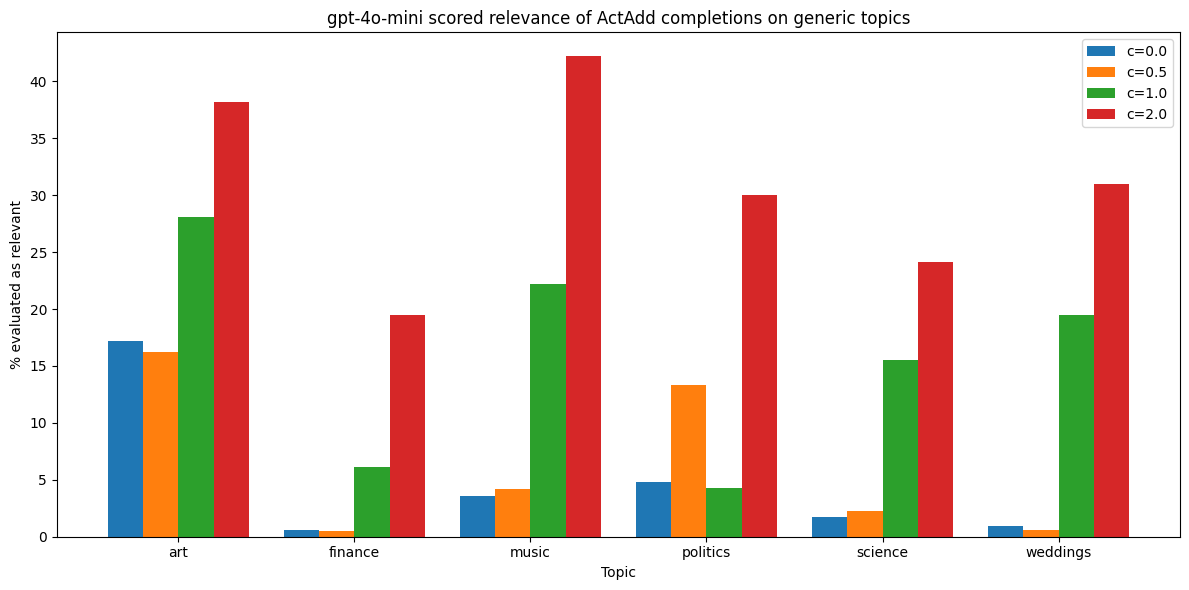

In [39]:
# Create the topic steering plot WITH baseline included
plt.figure(figsize=(12, 6))
x = np.arange(len(TOPICS))
width = 0.2

subtract = True
for i, coeff in enumerate(COEFFICIENTS):
    relevance_scores = [results[topic][i]*100 for topic in TOPICS]
    plt.bar(x + i * width, relevance_scores, width, label=f'c={coeff}')

plt.xlabel('Topic')
plt.ylabel('% evaluated as relevant')
plt.title('gpt-4o-mini scored relevance of ActAdd completions on generic topics')
plt.xticks(x + width * (len(COEFFICIENTS) - 1) / 2, TOPICS)

plt.legend()
plt.tight_layout()
plt.savefig(f"figures/{exp_name}.png", dpi=300)
plt.show()

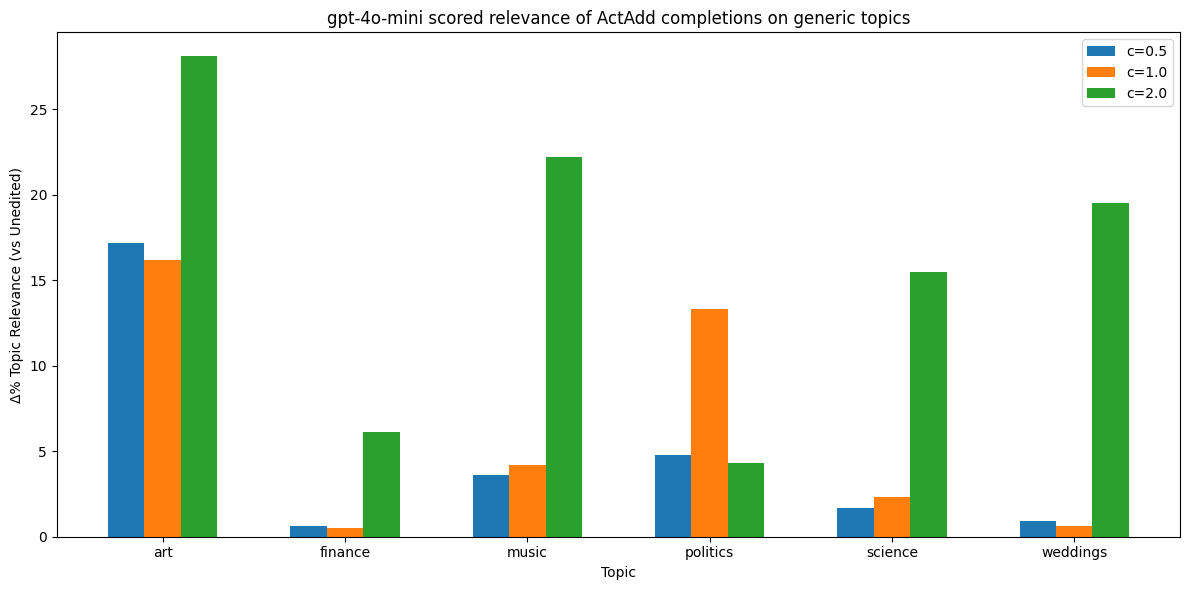

In [40]:
# Create the visualization WITHOUT baseline included (show diffs)
plt.figure(figsize=(12, 6))
x = np.arange(len(TOPICS))
width = 0.2

subtract = True
for i, coeff in enumerate(COEFFICIENTS[1:]):
    relevance_scores = [results[topic][i]*100 for topic in TOPICS]
    plt.bar(x + i * width, relevance_scores, width, label=f'c={coeff}')

plt.xlabel('Topic')
# plt.ylabel('% evaluated as relevant minus no-editing baseline')
plt.ylabel('Δ% Topic Relevance (vs Unedited)')
plt.title('gpt-4o-mini scored relevance of ActAdd completions on generic topics')
plt.xticks(x + width * (len(COEFFICIENTS[1:]) - 1) / 2, TOPICS)

plt.legend()
plt.tight_layout()
plt.savefig(f"figures/{exp_name}_diff.png", dpi=300)
plt.show()

In [33]:
# works better for long 32 tok imdb prompts:
# prompt_add, prompt_sub = pad_both("I talk about weddings constantly", "I do not talk about weddings constantly")
# coeff = 4.0

# XXX: paper used https://arxiv.org/pdf/2308.10248v3
# XXX: they also used ‘I went up to my friend and said’ as prompt, but
# XXX: imdb prompts are long so this works worse unless we truncate
# XXX: imdb prompts a bunch (what I've done here, to 16 chars.)
prompt_add, prompt_sub = pad_both("weddings", "")
coeff = 1.0

layer_completions = []
# layers = [2, 6, 16, 35]
layers = list(range(0, 48))
pbatch = [p[:16] for p in PROMPT_BATCH] # XXX: Cheating? See comment above
for layer in tqdm(layers + [-1]):
    if layer != -1:
      hooked_res = generate_hooked(pbatch, prompt_add, prompt_sub, layer, coeff) 
    else:
      hooked_res = generate_hooked(pbatch, prompt_add, prompt_sub, 0, 0) # baseline

    layer_completions.append([
        x.replace("<|endoftext|>", "") for x in model.to_string(hooked_res[:, 1:])
    ])
  
baseline_completion = layer_completions.pop()

100%|██████████| 49/49 [02:14<00:00,  2.75s/it]


In [34]:
# save
fname = f"results/{int(time.time())}-weddings.json"
with open(fname, "w") as f:
    json.dump({
        "layer_completions": layer_completions,
        "layers": layers,
        "baseline_completion": baseline_completion,
        "prompt_batch": PROMPT_BATCH,
        "meta": {
            "coeff": coeff,
            "prompt_add": prompt_add,
            "prompt_sub": prompt_sub,
            "seed": SEED,
            "act_name": act_name,
        }
    }, f)
    print(f"wrote {fname}")

wrote results/1732333137-weddings.json


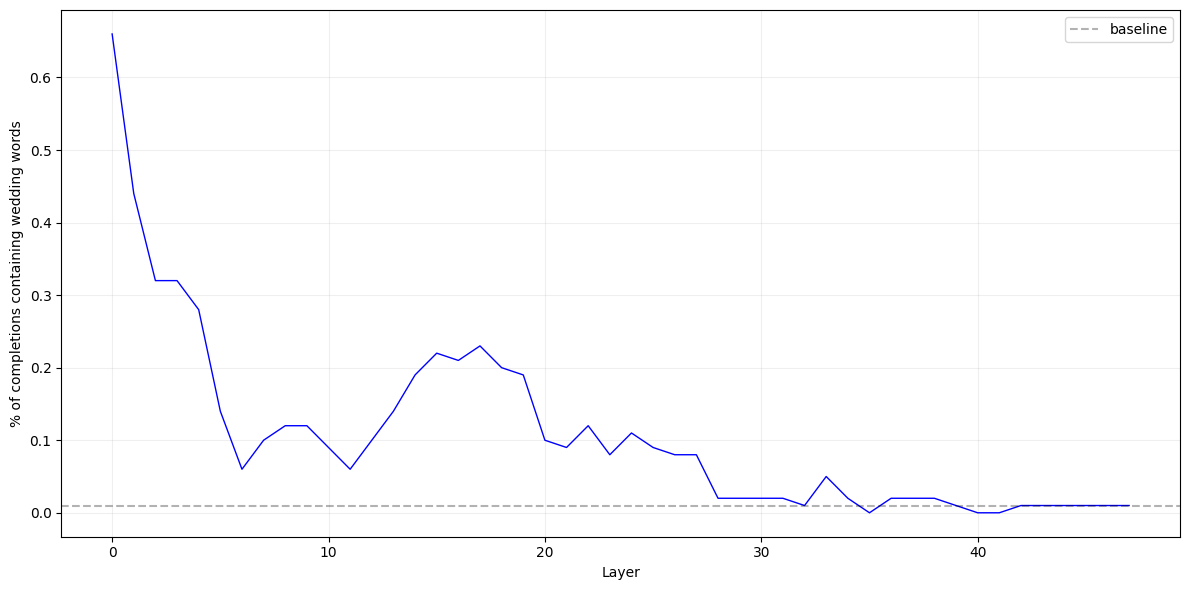

In [35]:
# Compute wedding-related completions % (figure 3)
wedding_words = (
    "wedding", "weddings", "wed", "marry", "married",
    "marriage", "bride", "groom", "honeymoon",
)

def contains_wedding_words(text: str) -> bool:
    assert isinstance(text, str), f"what the fuck is a '{type(text)}'"
    assert len(text) > 1, f"bruh wtf just '{text}' is all i get"
    return any(word in wedding_words for word in text.lower().split())

wedding_related_pct = [
    np.mean([contains_wedding_words(x) for x in layer_completions])
    for layer_completions in layer_completions
]
baseline_pct = np.mean([contains_wedding_words(x) for x in baseline_completion])

# Create the visualization
plt.figure(figsize=(12, 6))
plt.plot(layers, wedding_related_pct, 'b-', linewidth=1)
plt.axhline(y=baseline_pct, color='k', linestyle='--', alpha=0.3, label='baseline')

plt.xlabel('Layer')
plt.ylabel('% of completions containing wedding words')
plt.grid(True, alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

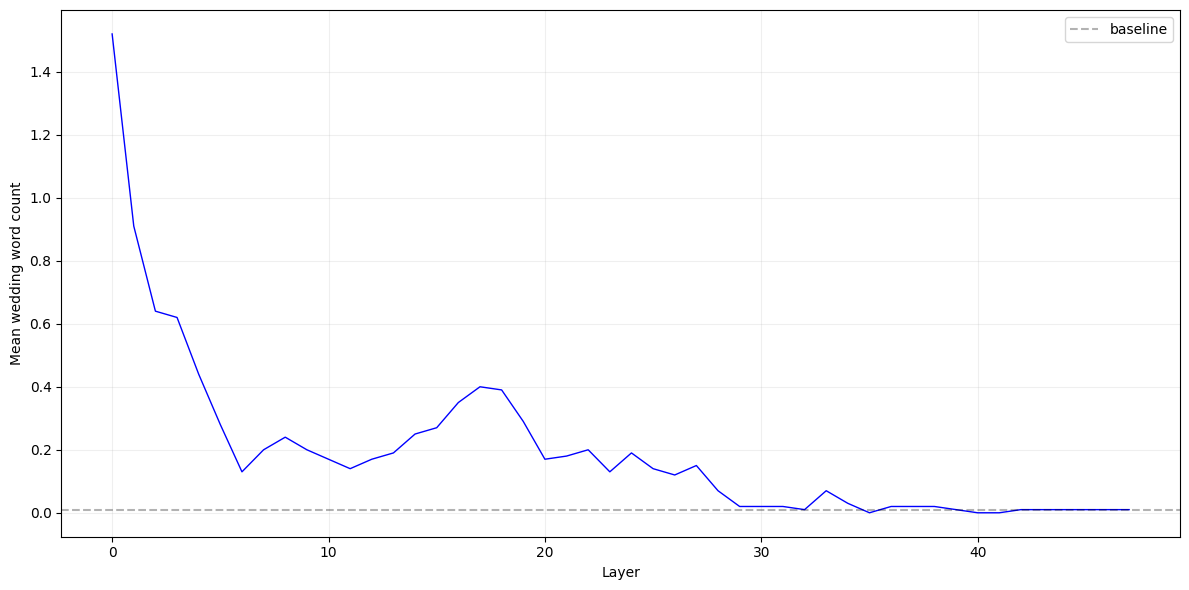

In [36]:
# Graph mean wedding word count per layer (figure 7)
def wedding_word_count(text: str) -> int:
    return sum(word in wedding_words for word in text.lower().split())


wedding_word_counts = [
    np.mean([wedding_word_count(x) for x in lc])
    for lc in layer_completions
]
baseline_count = np.mean([wedding_word_count(x) for x in baseline_completion])

# Create the visualization
plt.figure(figsize=(12, 6))
plt.plot(layers, wedding_word_counts, 'b-', linewidth=1)
plt.axhline(y=baseline_count, color='k', linestyle='--', alpha=0.3, label='baseline')

plt.xlabel('Layer')
plt.ylabel('Mean wedding word count')
plt.grid(True, alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

# Grid search



In [76]:
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import itertools
import json
import hashlib

In [266]:
PROMPT_BATCHES = {
  "positive": pd.read_csv("prompts/sentiment_imdb_POSITIVE_gridsearch_subset (1).csv")["input"].tolist()[:60],
  "negative": pd.read_csv("prompts/sentiment_imdb_NEGATIVE_gridsearch_subset (1).csv")["input"].tolist()[:60],
  "toxicity": pd.read_csv("prompts/toxicity_pol_gridsearch_subset (1).csv")["input"].tolist()[:60],
}
SELECTION = "positive"

PROMPT_BATCH = PROMPT_BATCHES[SELECTION]

prompt_add, prompt_sub = {
  "negative": ("Love", "Hate"),
  "positive": ("Hate", "Love"), # padding reasons: " " is prob better
  "toxicity": ("Love", "Hate"),
}[SELECTION]

max_new_tokens = 32 if SELECTION == "toxicity" else 64

sampling_kwargs = dict(temperature=1.0, top_p=1.0) # , freq_penalty=1.0) # for llama, new ones
SEED = 0

grid_to_sweep = list(itertools.product(range(0, 23, 3), [-3, -1, 0, 1, 3, 6, 12, 18]))

exp_name = f"{SELECTION}_n{len(grid_to_sweep)}"
exp_folder = f"grid_results/{exp_name}"
os.makedirs(exp_folder, exist_ok=True)
with open(f"{exp_folder}/meta.json", "w") as f:
  json.dump({
    "prompt_add": prompt_add,
    "prompt_sub": prompt_sub,
    "max_new_tokens": max_new_tokens,
    "sampling_kwargs": sampling_kwargs,
    "PROMPT_BATCH": PROMPT_BATCH,
  }, f)
  print(f"wrote {f.name}")

for i, (l, c) in tqdm(enumerate(grid_to_sweep), total=len(grid_to_sweep)):
  results = generate_hooked(PROMPT_BATCH, prompt_add, prompt_sub, l, c, verbose=False, max_new_tokens=64)
  results_str = model.to_string(results[:, 1:])

  output = model.forward(results, return_type="loss", loss_per_token=True)

  # Create attention mask that excludes EOS tokens
  attention_mask = (results != model.tokenizer.eos_token_id)

  # output.shape is 1 less than results.shape, exclude last token (we cant compute loss for the last token)
  attention_mask = attention_mask[:, :-1]

  # compute perplexities :)
  perplexities = ((attention_mask * output).sum(-1) / attention_mask.sum(-1)).exp().tolist()

  # and json cuz idk why not
  with open(f"{exp_folder}/{i}_l{l}_c{c}.json", "w") as f:
    json.dump({
      "prompt_batch": PROMPT_BATCH,
      "completions": results_str,
      "perplexities": perplexities,
      "layer": l,
      "coeff": c,
      # TODO: More metrics (sentiment, toxicity, % coherent, ?)
    }, f)

wrote grid_results/positive_n64/meta.json


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [07:23<00:00,  6.92s/it]


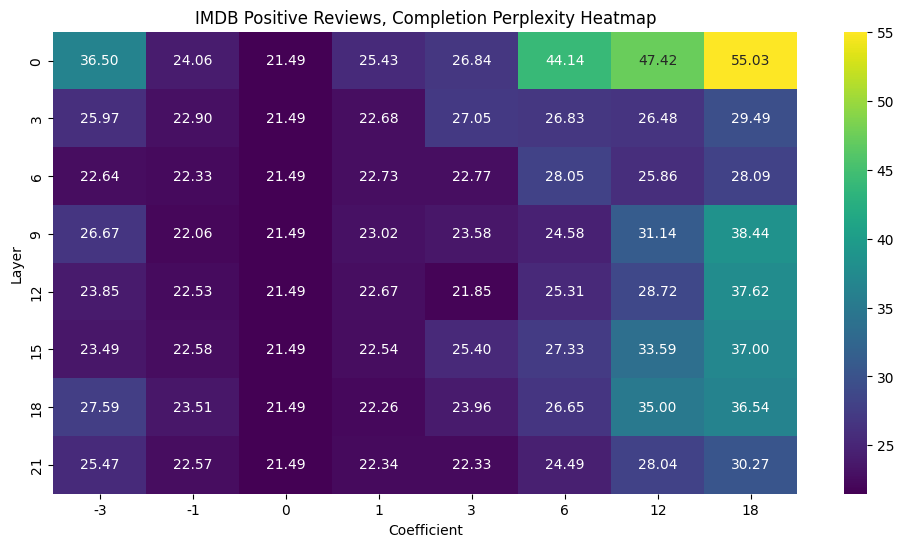

In [276]:
# Read all the json files and plot them
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(exp_folder: str, SELECTION: str, values: str = "perplexity"):
    files = os.listdir(exp_folder)
    data = []

    for f in files:
        if f == "meta.json":
            continue

        with open(exp_folder + "/" + f) as fp:
            d = json.load(fp)
            data.append({
                "layer": d["layer"],
                "coeff": d["coeff"], 
                "perplexity": np.mean(d["perplexities"]), # avg over batch
                "sentiment": np.mean(d["sentiment"]),
            })

    df = pd.DataFrame(data)
    pivot = df.pivot(index="layer", columns="coeff", values=values)

    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="viridis", annot=True, fmt='.2f')

    dataset_name = f"IMDB {SELECTION.title()} Reviews" if SELECTION != "toxicity" else "RealToxicityPrompts"
    plt.title(f"{dataset_name}, Completion {values.title()} Heatmap") 

    plt.ylabel("Layer")
    plt.xlabel("Coefficient")
    plt.savefig(f"figures/{exp_name}_{values}_heatmap.png", dpi=300)
    plt.show()

plot_heatmap(exp_folder, SELECTION, "perplexity")

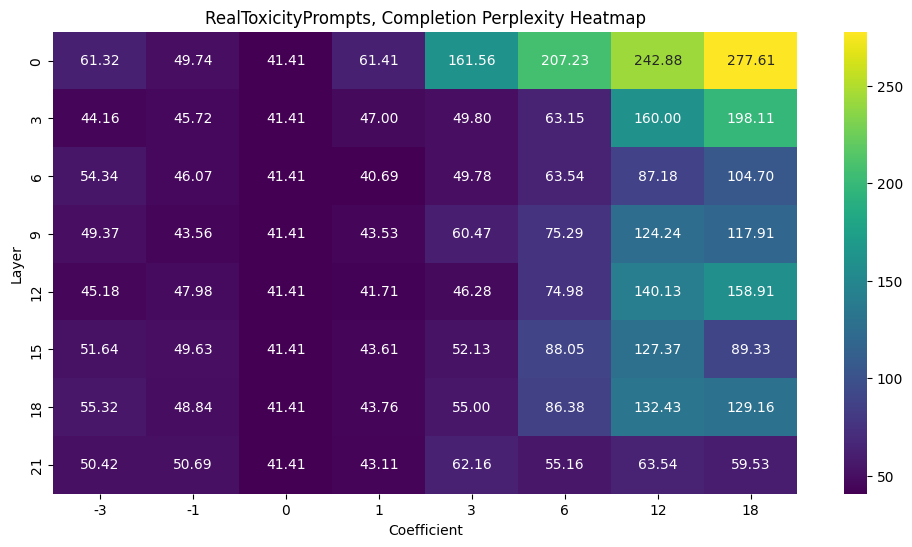

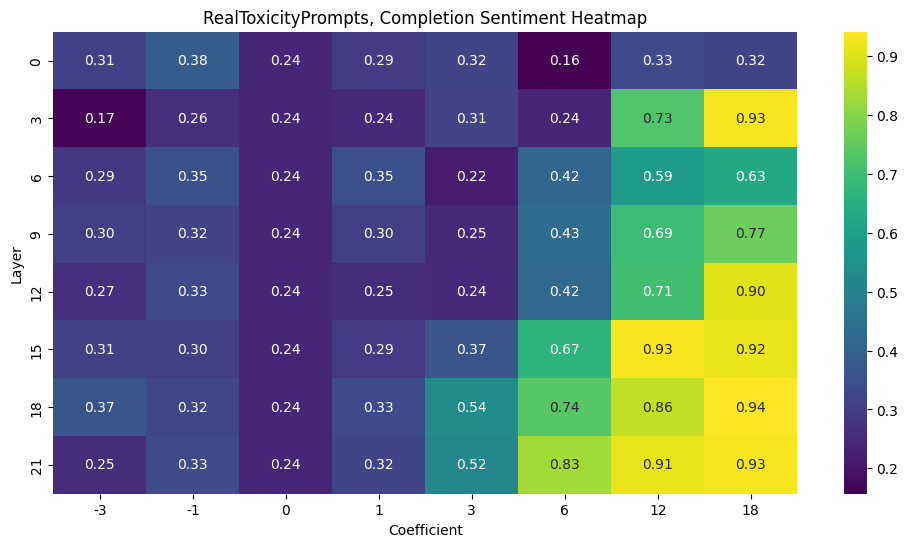

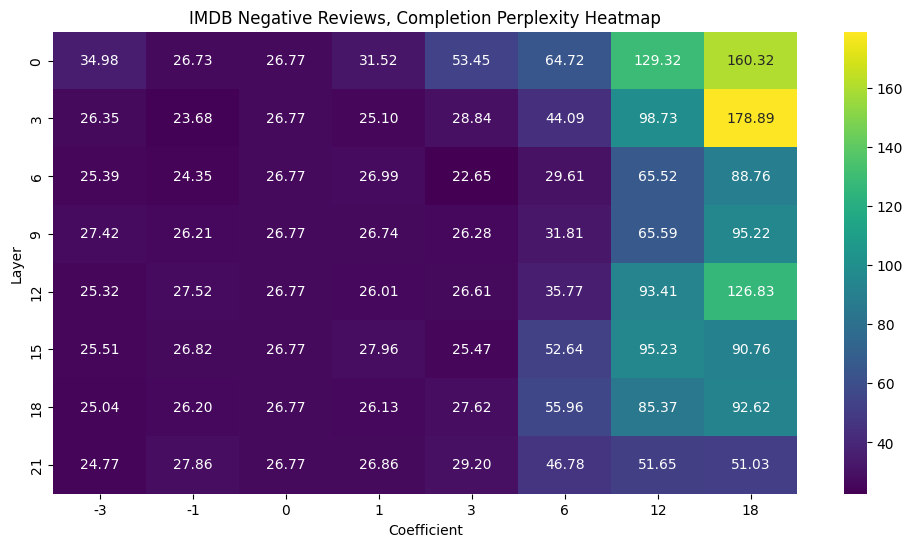

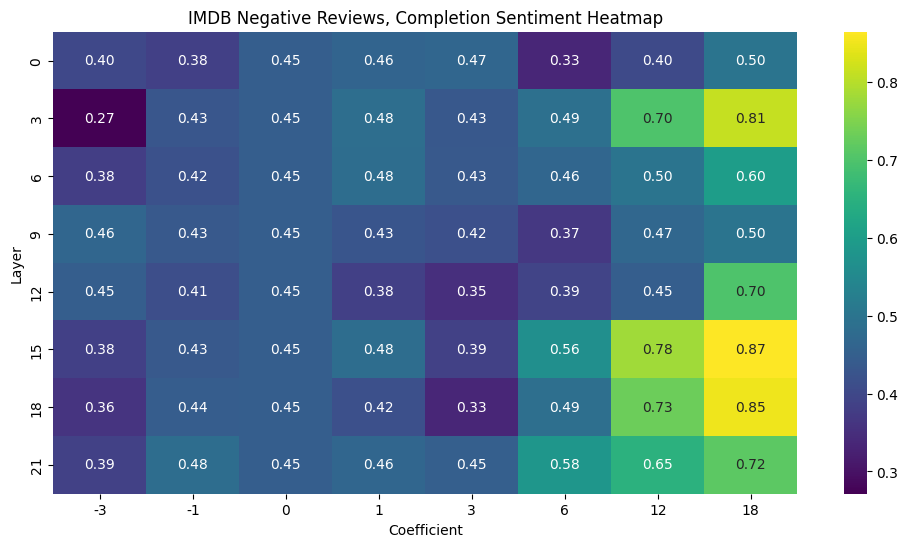

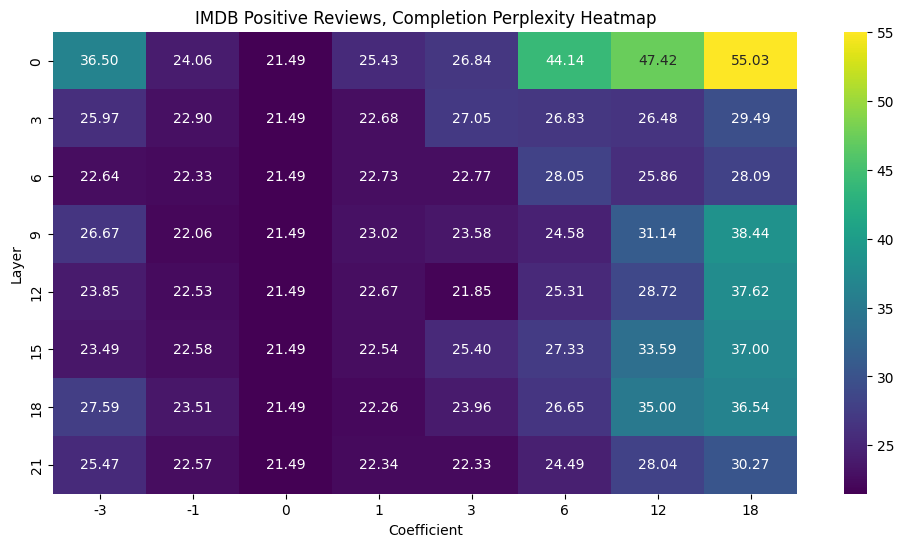

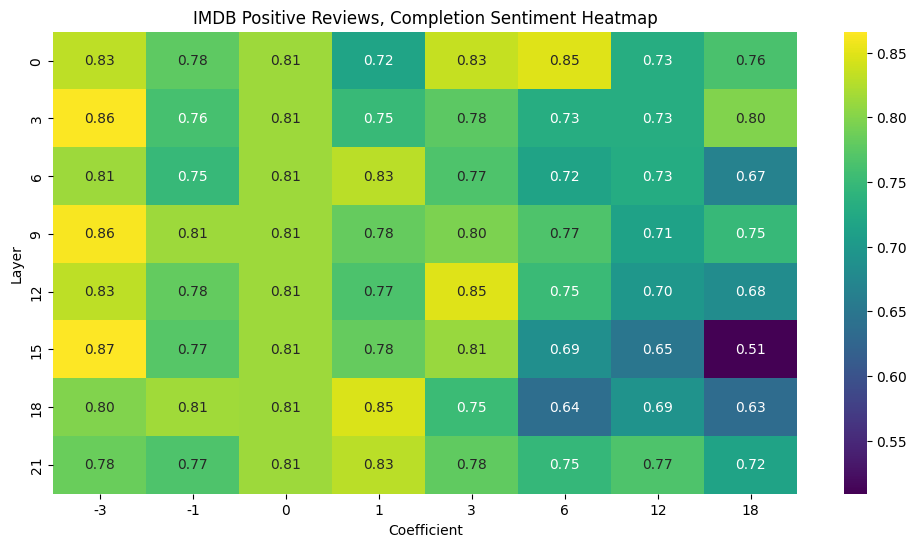

In [278]:
# Plot all (for when plotting code updates)

for exp_folder in os.listdir("grid_results"):
  selected_dataset = exp_folder.split("_")[0]
  plot_heatmap(f"grid_results/{exp_folder}", selected_dataset, "perplexity")
  plot_heatmap(f"grid_results/{exp_folder}", selected_dataset, "sentiment")
